
# Asset Risk Prediction — TensorFlow DNN (AI4I 2020)

End-to-end notebook to build a **predictive maintenance / asset-risk** classifier using a **TensorFlow** deep neural network on the **AI4I 2020 Predictive Maintenance** dataset.

**What you get:**
- One-click **environment setup** with pinned, compatible package versions
- **Data fetch** from UCI via `ucimlrepo` (with simple fallback option)
- **Feature engineering** (temperature deltas, power proxy, wear ratios)
- **Train/Validation/Test** split with **class weighting** for imbalance
- **TensorFlow** model with dropout + batch normalisation + early stopping
- **ROC** & **Precision–Recall** curves, **calibration curve**, confusion matrix
- Exported **risk report** CSV, saved **model** and **metrics** for your repo



## 1. Environment Setup
Run this cell first. It ensures TensorFlow and friends are installed in versions that play nicely together.


In [15]:

# import sys, subprocess, pkgutil

# def pip_install(*args):
#     cmd = [sys.executable, "-m", "pip", "install", *args]
#     print("Running:", " ".join(cmd))
#     subprocess.check_call(cmd)

# # Upgrade pip, then install pinned, compatible versions
# pip_install("--upgrade", "pip", "wheel", "setuptools")
# pip_install("numpy<2.0", "tensorflow==2.16.1", "scikit-learn", "pandas", "matplotlib", "seaborn", "joblib", "ucimlrepo")



## 2. Imports & Version Check


In [16]:

import os, sys, math, json, textwrap, warnings
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score, average_precision_score, precision_recall_curve,
    roc_curve, confusion_matrix, classification_report
)
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.isotonic import IsotonicRegression
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow import keras
from keras import layers

from joblib import dump
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (8, 5)

print("Python:", sys.version)
print("NumPy:", np.__version__)
print("TensorFlow:", tf.__version__)


Python: 3.13.7 (tags/v3.13.7:bcee1c3, Aug 14 2025, 14:15:11) [MSC v.1944 64 bit (AMD64)]
NumPy: 2.3.2
TensorFlow: 2.20.0



## 3. Paths & Output Folders


In [17]:

ROOT = Path.cwd()
OUT = ROOT / "outputs"
OUT.mkdir(parents=True, exist_ok=True)



## 4. Load Dataset (UCI AI4I 2020)
This uses `ucimlrepo` to fetch the dataset by ID (601). No manual download needed.


In [18]:
# Manual CSV loading
import pandas as pd

# Load the dataset from a local CSV file
df = pd.read_csv('predictive_maintenance.csv')

# Extract features and target
feature_cols = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 
               'Torque [Nm]', 'Tool wear [min]', 'Type']
target_col = 'Target'  # Changed from 'Machine failure' to 'Target'

X_raw = df[feature_cols].copy()
X_raw.columns = ['air_temp_k', 'proc_temp_k', 'rpm', 'torque_nm', 'tool_wear_min', 'Type']
y_raw = df[target_col].astype(int)

print("Features shape:", X_raw.shape, "| Target shape:", y_raw.shape)
pd.DataFrame({"col": X_raw.columns}).head()

Features shape: (10000, 6) | Target shape: (10000,)


,col
0,air_temp_k
1,proc_temp_k
2,rpm
3,torque_nm
4,tool_wear_min



## 5. Basic Cleaning & Feature Engineering
Create simple domain features that often help: temperature delta, a crude power proxy (rpm × torque), and wear per power.


In [19]:
# Standardise column names for convenience
X = X_raw.rename(columns={
    'Air temperature': 'air_temp_k',
    'Process temperature': 'proc_temp_k',
    'Rotational speed': 'rpm',
    'Torque': 'torque_nm',
    'Tool wear': 'tool_wear_min',
})

# Categorical
X['Type'] = X['Type'].astype('category')

# Engineered features
X['temp_diff_k']    = X['proc_temp_k'] - X['air_temp_k']
X['power_proxy']    = X['rpm'] * X['torque_nm']
X['wear_per_power'] = X['tool_wear_min'] / (X['power_proxy'] + 1e-6)

numeric_features = [
    'air_temp_k','proc_temp_k','temp_diff_k',
    'rpm','torque_nm','power_proxy',
    'tool_wear_min','wear_per_power'
]
categorical_features = ['Type']

target = y_raw
df = pd.concat([X[numeric_features + categorical_features], target.rename("failure")], axis=1)
df.head()

,air_temp_k,proc_temp_k,temp_diff_k,rpm,torque_nm,power_proxy,tool_wear_min,wear_per_power,Type,failure
0,298.1,308.6,10.5,1551,42.8,66382.8,0,0.000000,M,0
1,298.2,308.7,10.5,1408,46.3,65190.4,3,0.000046,L,0
2,298.1,308.5,10.4,1498,49.4,74001.2,5,0.000068,L,0
3,298.2,308.6,10.4,1433,39.5,56603.5,7,0.000124,L,0
4,298.2,308.7,10.5,1408,40.0,56320.0,9,0.000160,L,0



## 6. Quick EDA


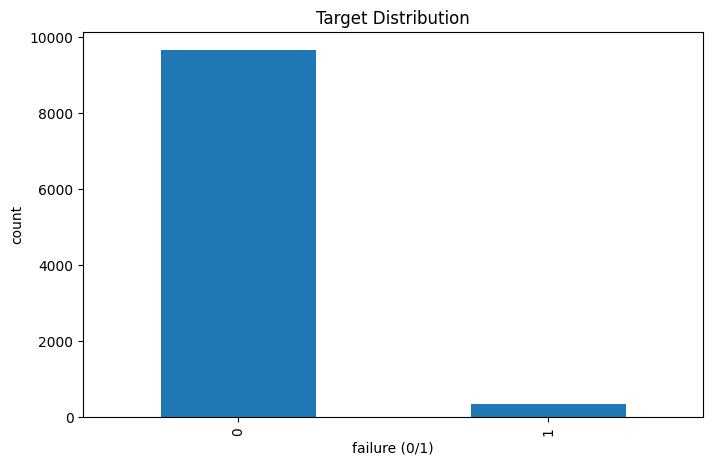

,count,mean,std,min,25%,50%,75%,max
air_temp_k,10000.0,300.004930,2.000259,295.3,298.300000,300.100000,301.500000,304.500000
proc_temp_k,10000.0,310.005560,1.483734,305.7,308.800000,310.100000,311.100000,313.800000
temp_diff_k,10000.0,10.000630,1.001094,7.6,9.300000,9.800000,11.000000,12.100000
rpm,10000.0,1538.776100,179.284096,1168.0,1423.000000,1503.000000,1612.000000,2886.000000
torque_nm,10000.0,39.986910,9.968934,3.8,33.200000,40.100000,46.800000,76.600000
power_proxy,10000.0,59967.147040,10193.093881,10966.8,53105.400000,59883.900000,66873.750000,99980.400000
tool_wear_min,10000.0,107.951000,63.654147,0.0,53.000000,108.000000,162.000000,253.000000
wear_per_power,10000.0,0.001859,0.001181,0.0,0.000881,0.001786,0.002717,0.013426


In [20]:

ax = df['failure'].value_counts().sort_index().plot(kind='bar')
ax.set_xlabel('failure (0/1)'); ax.set_ylabel('count'); ax.set_title('Target Distribution')
plt.show()

df[numeric_features].describe().T



## 7. Train / Validation / Test Split


In [21]:

X_all = df[numeric_features + categorical_features].copy()
y_all = df['failure'].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all, test_size=0.20, random_state=42, stratify=y_all
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.20, random_state=42, stratify=y_train
)

len(X_train), len(X_val), len(X_test)


(6400, 1600, 2000)


## 8. Preprocessing
Standardise numeric features, one-hot encode categorical `Type`, and build the final matrices.


In [22]:

pre_num = StandardScaler()
pre_cat = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

# Fit transforms
X_train_num = pre_num.fit_transform(X_train[numeric_features])
X_val_num   = pre_num.transform(X_val[numeric_features])
X_test_num  = pre_num.transform(X_test[numeric_features])

X_train_cat = pre_cat.fit_transform(X_train[categorical_features])
X_val_cat   = pre_cat.transform(X_val[categorical_features])
X_test_cat  = pre_cat.transform(X_test[categorical_features])

# Concatenate
import numpy as np
Xtr = np.hstack([X_train_num, X_train_cat])
Xva = np.hstack([X_val_num,   X_val_cat])
Xte = np.hstack([X_test_num,  X_test_cat])

feature_names = numeric_features + list(pre_cat.get_feature_names_out(categorical_features))
Xtr.shape, Xva.shape, Xte.shape


((6400, 11), (1600, 11), (2000, 11))


## 9. Handle Class Imbalance
Compute class weights so the model pays more attention to the minority class.


In [23]:

classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weight = {int(c): float(w) for c, w in zip(classes, weights)}
class_weight


{0: 0.5175481158013909, 1: 14.746543778801843}


## 10. TensorFlow Model — Build & Train
Simple DNN with batch normalisation and dropout. We monitor validation loss and AUCs.


In [24]:

tf.random.set_seed(42)
inputs = keras.Input(shape=(Xtr.shape[1],), name="features")
x = layers.Dense(128, activation='relu')(inputs)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.25)(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.25)(x)
x = layers.Dense(32, activation='relu')(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = keras.Model(inputs=inputs, outputs=outputs, name="asset_risk_dnn")
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=[keras.metrics.AUC(name='auc', curve='ROC'),
             keras.metrics.AUC(name='pr_auc', curve='PR')]
)
model.summary()


Model: "asset_risk_dnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ features (InputLayer)           │ (None, 11)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,673 (49.50 KB)

 Trainable params: 12,289 (48.00 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - auc: 0.7932 - loss: 0.6879 - pr_auc: 0.2269 - val_auc: 0.9341 - val_loss: 0.5934 - val_pr_auc: 0.5441 - learning_rate: 0.0010
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9086 - loss: 0.4284 - pr_auc: 0.3778 - val_auc: 0.9430 - val_loss: 0.4603 - val_pr_auc: 0.5310 - learning_rate: 0.0010
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.9330 - loss: 0.3505 - pr_auc: 0.4696 - val_auc: 0.9537 - val_loss: 0.3577 - val_pr_auc: 0.5997 - learning_rate: 0.0010
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.9415 - loss: 0.3200 - pr_auc: 0.4808 - val_auc: 0.9518 - val_loss: 0.2737 - val_pr_auc: 0.5703 - learning_rate: 0.0010
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9518 - loss: 0.2888 - pr_auc: 0.5706 - val_auc: 0.9499 - val_loss: 0.2183 - val_pr_auc: 0.4998 - learning_rate: 0.0010
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - auc: 0.9526 - loss: 0.2833 - pr_auc: 0.5352 - 

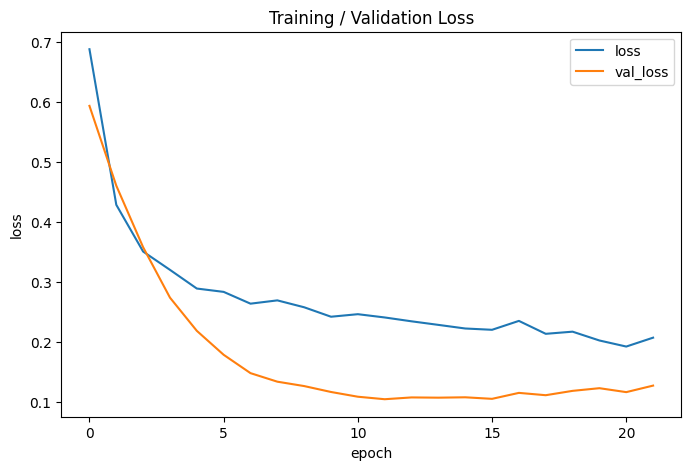

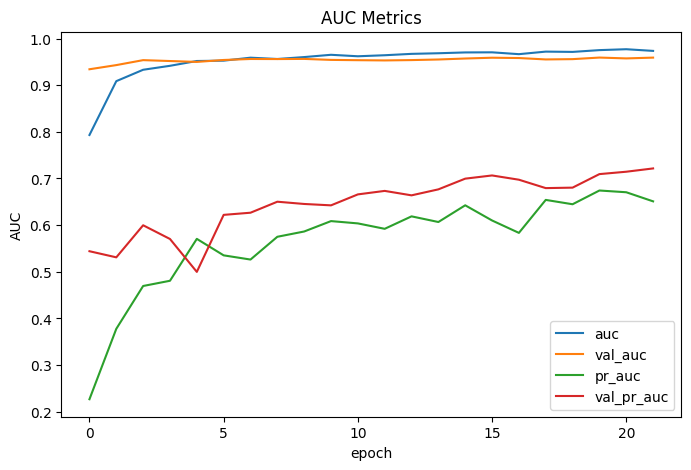

In [25]:

callbacks = [
    keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True, monitor='val_loss'),
    keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5, min_lr=1e-5, monitor='val_loss')
]

hist = model.fit(
    Xtr, y_train,
    validation_data=(Xva, y_val),
    epochs=100,
    batch_size=256,
    class_weight=class_weight,
    callbacks=callbacks,
    verbose=1
)

# Training curves
hist_df = pd.DataFrame(hist.history)
ax = hist_df[['loss','val_loss']].plot(title='Training / Validation Loss')
ax.set_xlabel('epoch'); ax.set_ylabel('loss')
plt.show()

ax = hist_df[['auc','val_auc','pr_auc','val_pr_auc']].plot(title='AUC Metrics')
ax.set_xlabel('epoch'); ax.set_ylabel('AUC')
plt.show()



## 11. Evaluation on Test Set
We compute ROC-AUC, PR-AUC, plot the curves, and show a confusion matrix at threshold 0.5.


ROC AUC: 0.975 | PR AUC: 0.673


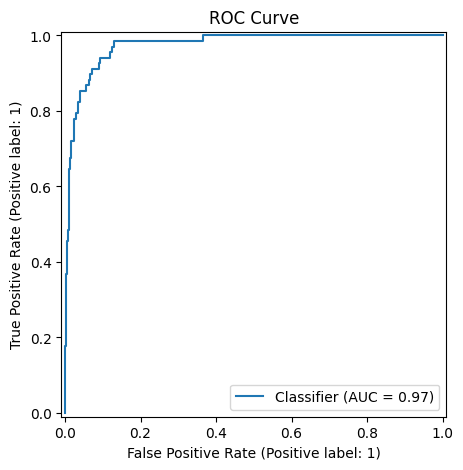

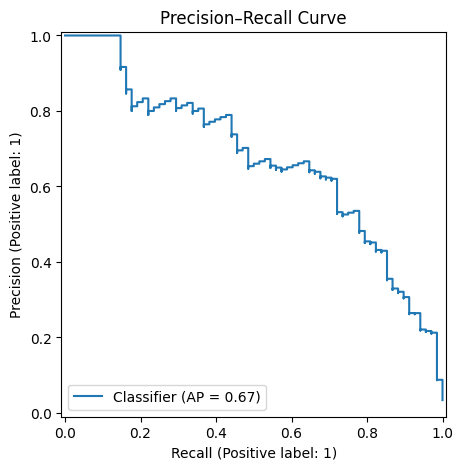

Confusion Matrix:
 [[1908   24]
 [  24   44]]

Classification Report:
               precision    recall  f1-score   support

           0      0.988     0.988     0.988      1932
           1      0.647     0.647     0.647        68

    accuracy                          0.976      2000
   macro avg      0.817     0.817     0.817      2000
weighted avg      0.976     0.976     0.976      2000



In [26]:

from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay

proba = model.predict(Xte, verbose=0).ravel()

roc = roc_auc_score(y_test, proba)
pr  = average_precision_score(y_test, proba)
print(f"ROC AUC: {roc:.3f} | PR AUC: {pr:.3f}")

# ROC curve
RocCurveDisplay.from_predictions(y_test, proba)
plt.title('ROC Curve')
plt.show()

# PR curve
PrecisionRecallDisplay.from_predictions(y_test, proba)
plt.title('Precision–Recall Curve')
plt.show()

# Confusion matrix at 0.5
pred = (proba >= 0.5).astype(int)
cm = confusion_matrix(y_test, pred)
print('Confusion Matrix:\n', cm)
print('\nClassification Report:\n', classification_report(y_test, pred, digits=3))



## 12. Probability Calibration (Isotonic)
We calibrate probabilities using validation predictions, then evaluate again on the test set.


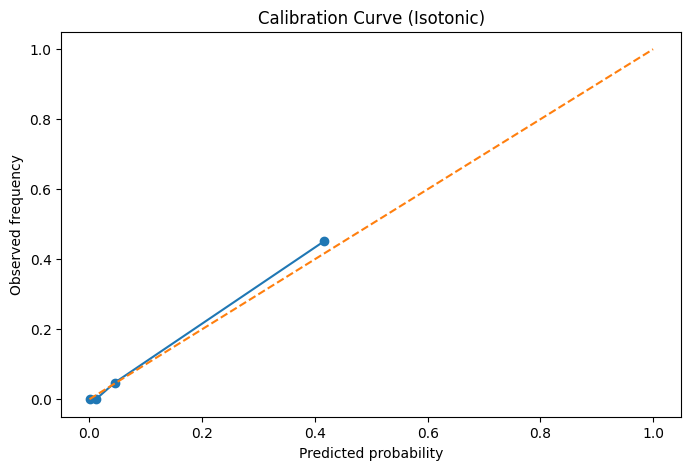

Calibrated ROC AUC: 0.972 | Calibrated PR AUC: 0.640


In [27]:

proba_val = model.predict(Xva, verbose=0).ravel()
cal = IsotonicRegression(out_of_bounds='clip')
cal.fit(proba_val, y_val)

proba_cal = cal.predict(proba)

# Calibration curve
from sklearn.calibration import calibration_curve
prob_true, prob_pred = calibration_curve(y_test, proba_cal, n_bins=10, strategy='quantile')
plt.plot(prob_pred, prob_true, marker='o')
plt.plot([0,1],[0,1],'--')
plt.title('Calibration Curve (Isotonic)')
plt.xlabel('Predicted probability'); plt.ylabel('Observed frequency')
plt.show()

roc_cal = roc_auc_score(y_test, proba_cal)
pr_cal  = average_precision_score(y_test, proba_cal)
print(f"Calibrated ROC AUC: {roc_cal:.3f} | Calibrated PR AUC: {pr_cal:.3f}")



## 13. Risk Report & Artifacts
Export a ranked list of asset IDs with calibrated risk scores. Save the model, calibrator, and metrics.


In [28]:
# Try to use 'UDI' as an ID if present
id_series = X_raw['UDI'] if 'UDI' in X_raw.columns else pd.Series(X_test.index, index=X_test.index, name='id')
ids_test = id_series.loc[X_test.index]

risk_report = pd.DataFrame({
    'id': ids_test.values,
    'risk_score': proba_cal
}).sort_values('risk_score', ascending=False)

risk_path = OUT / "risk_report.csv"
risk_report.to_csv(risk_path, index=False)
print("Saved risk report to:", risk_path.resolve())

# Save model and calibrator - ADD .keras extension
model_path = OUT / "tf_model.keras"
model.save(model_path)
dump(cal, OUT / "isotonic_calibrator.joblib")

# Save metrics
metrics_txt = OUT / "metrics.txt"
metrics_txt.write_text(f"""Asset Risk Prediction — TensorFlow DNN
ROC AUC (raw): {roc:.3f}
PR  AUC (raw): {pr:.3f}
ROC AUC (cal): {roc_cal:.3f}
PR  AUC (cal): {pr_cal:.3f}
Confusion matrix (0.5): {cm.tolist()}
""", encoding="utf-8")
print("Saved model, calibrator and metrics to:", OUT.resolve())

Saved risk report to: C:\Users\mturo\Desktop\scc\Asset-Risk-Prediction-DNN-Model\outputs\risk_report.csv
Saved model, calibrator and metrics to: C:\Users\mturo\Desktop\scc\Asset-Risk-Prediction-DNN-Model\outputs


In [29]:
# Standardise column names for convenience
X = X_raw.rename(columns={
    'Air temperature': 'air_temp_k',
    'Process temperature': 'proc_temp_k',
    'Rotational speed': 'rpm',
    'Torque': 'torque_nm',
    'Tool wear': 'tool_wear_min',
})

# Categorical
X['Type'] = X['Type'].astype('category')

# Engineered features
X['temp_diff_k']    = X['proc_temp_k'] - X['air_temp_k']
X['power_proxy']    = X['rpm'] * X['torque_nm']
X['wear_per_power'] = X['tool_wear_min'] / (X['power_proxy'] + 1e-6)

numeric_features = [
    'air_temp_k','proc_temp_k','temp_diff_k',
    'rpm','torque_nm','power_proxy',
    'tool_wear_min','wear_per_power'
]
categorical_features = ['Type']

target = y_raw
df = pd.concat([X[numeric_features + categorical_features], target.rename("failure")], axis=1)
df.head()

,air_temp_k,proc_temp_k,temp_diff_k,rpm,torque_nm,power_proxy,tool_wear_min,wear_per_power,Type,failure
0,298.1,308.6,10.5,1551,42.8,66382.8,0,0.000000,M,0
1,298.2,308.7,10.5,1408,46.3,65190.4,3,0.000046,L,0
2,298.1,308.5,10.4,1498,49.4,74001.2,5,0.000068,L,0
3,298.2,308.6,10.4,1433,39.5,56603.5,7,0.000124,L,0
4,298.2,308.7,10.5,1408,40.0,56320.0,9,0.000160,L,0



## 14. (Optional) Simple Permutation Importance
Estimate feature influence by measuring PR-AUC drop when shuffling each feature (on the test set).


In [30]:

def pr_auc_drop_on_shuffle(X_matrix, y_true, base_proba, n_repeats=3, seed=42):
    rng = np.random.default_rng(seed)
    base = average_precision_score(y_true, base_proba)
    drops = []
    for j, name in enumerate(feature_names):
        scores = []
        for _ in range(n_repeats):
            Xp = X_matrix.copy()
            rng.shuffle(Xp[:, j])
            p = model.predict(Xp, verbose=0).ravel()
            p = cal.predict(p)
            scores.append(average_precision_score(y_true, p))
        drops.append((name, base - float(np.mean(scores))))
    return pd.DataFrame(drops, columns=['feature','pr_auc_drop']).sort_values('pr_auc_drop', ascending=False)

perm_importance = pr_auc_drop_on_shuffle(Xte, y_test.values, proba_cal, n_repeats=3)
perm_importance.head(10)


,feature,pr_auc_drop
4,torque_nm,0.400760
3,rpm,0.296007
2,temp_diff_k,0.208047
5,power_proxy,0.169770
6,tool_wear_min,0.143701
0,air_temp_k,0.143398
7,wear_per_power,0.104319
9,Type_L,0.017717
10,Type_M,-0.002509
8,Type_H,-0.006413



## 15. Summary (Copy for README)
Trained a **TensorFlow** deep neural network on the **AI4I 2020** dataset to predict asset failures.  
Engineered rolling-window–style features (temperature deltas, load proxy, wear ratios), handled class imbalance with **class weights**, and evaluated with **ROC-AUC** and **PR-AUC**.  
Applied **isotonic calibration** to produce well-calibrated risk scores and exported a **ranked at-risk assets report** along with saved model artifacts.
